In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

In [3]:
data = Table.read('galSpecExtra-dr8.fits')
data = data[data['PLATEID'] > 0]
data_tot = data[data['LGM_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['SPECSFR_TOT_P50'] > -9999]

In [4]:
import seaborn as sns

ValueError: grey is not a valid palette name

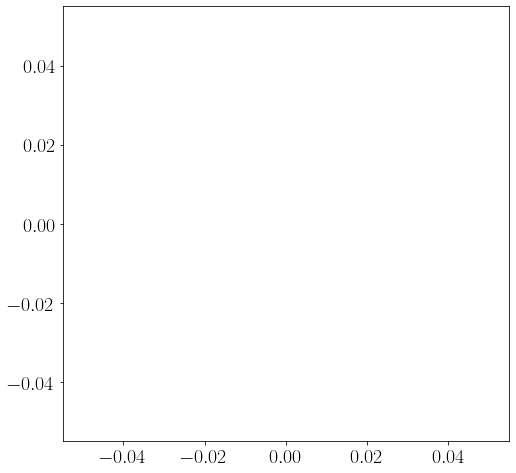

In [6]:
byg = data_tot[data_tot['SPECOBJID'] == '1633681641756977152']
jhr = data_tot[data_tot['SPECOBJID'] == '324379878126282752 ']

plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(data_tot['LGM_TOT_P50'][::100], dtype='f4'),
                 y=np.array(data_tot['SPECSFR_TOT_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="grey", levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('$\lg(M/M_\odot)$')
ax.set_ylabel('$\lg(\mathrm{sSFR/yr})$')
plt.errorbar(byg['LGM_FIB_P50'],
             byg['SPECSFR_FIB_P50'],
             fmt='o',
             capsize=5,
             xerr=[
                 byg['LGM_TOT_P50'] - byg['LGM_TOT_P16'],
                 byg['LGM_TOT_P84'] - byg['LGM_TOT_P50']
             ],
             yerr=[
                 byg['SPECSFR_TOT_P50'] - byg['SPECSFR_TOT_P16'],
                 byg['SPECSFR_TOT_P84'] - byg['SPECSFR_TOT_P50']
             ],
             color='crimson',
             label='$\mathrm{SN\ 2018byg}$')
plt.errorbar(jhr['LGM_FIB_P50'],
             jhr['SPECSFR_FIB_P50'],
             fmt='o',
             capsize=5,
             xerr=[
                 jhr['LGM_TOT_P50'] - jhr['LGM_TOT_P16'],
                 jhr['LGM_TOT_P84'] - jhr['LGM_TOT_P50']
             ],
             yerr=[
                 jhr['SPECSFR_TOT_P50'] - jhr['SPECSFR_TOT_P16'],
                 jhr['SPECSFR_TOT_P84'] - jhr['SPECSFR_TOT_P50']
             ],
             color='orange',
             label='$\mathrm{SN\ 2016jhr}$')
plt.legend()
plt.xlim(8, 13)
plt.ylim(-14, -8)
plt.show()